In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# Uninstall any existing OpenMM version
!pip uninstall -y openmm

# Reinstall OpenMM
!pip install --upgrade openmm


Found existing installation: OpenMM 8.2.0
Uninstalling OpenMM-8.2.0:
  Successfully uninstalled OpenMM-8.2.0


['Collecting openmm',
 '  Using cached OpenMM-8.2.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (844 bytes)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from openmm) (1.26.4)',
 'Using cached OpenMM-8.2.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (12.3 MB)',
 'Installing collected packages: openmm',
 'Successfully installed openmm-8.2.0']

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Nov 12 12:40:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  7

In [ ]:
import os
os.environ['OPENMM_CUDA_COMPILER'] = "/usr/local/cuda/bin/nvcc"
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda/lib64:/usr/lib64-nvidia"

In [ ]:
import os
os._exit(00)

In [ ]:
from openmm import Platform

platform_names = [Platform.getPlatform(i).getName() for i in range(Platform.getNumPlatforms())]
print("Available Platforms:", platform_names)

try:
    platform = Platform.getPlatformByName('CUDA')
    print("CUDA platform is available!")
except Exception as e:
    print(f"CUDA platform not found: {e}")

Available Platforms: ['Reference', 'CPU']
CUDA platform not found: There is no registered Platform called "CUDA"


In [ ]:
!pip install numpy scipy matplotlib biopython mdanalysis openmm

In [ ]:
!pip install biopython

In [ ]:
from Bio import PDB

# Define the PDB ID for alpha-synuclein
pdb_id = "1XQ8"
output_file = f"{pdb_id}.pdb"

# Create a PDB list object
pdb_list = PDB.PDBList()

# Download the PDB file
print(f"Downloading PDB file for {pdb_id}...")
pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')

print(f"Downloaded file: {output_file}")

Downloaded file: 1XQ8.pdb


In [ ]:
!mv pdb1xq8.ent alpha_synuclein.pdb

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt

# Load the predicted alpha-synuclein structure
u = mda.Universe("alpha_synuclein.pdb")
print(f"Loaded structure: {u}")

Loaded structure: <Universe with 2017 atoms>


In [ ]:
from openmm import app, Platform, unit, LangevinIntegrator
from openmm.app import PDBFile, Modeller, ForceField, Simulation, StateDataReporter
import sys

# Step 1: Load the PDB file
pdb = PDBFile('alpha_synuclein.pdb')

# Step 2: Load the force field
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')

# Step 3: Prepare the model by adding water solvent
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, model='tip3p', padding=1.0*unit.nanometers)

# Step 4: Set up the system
system = forcefield.createSystem(modeller.topology,
                                 nonbondedMethod=app.PME,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds)

# Step 5: Create the integrator using Langevin dynamics
temperature = 300 * unit.kelvin
friction = 1.0 / unit.picosecond
time_step = 0.002 * unit.picoseconds
integrator = LangevinIntegrator(temperature, friction, time_step)

# Step 6: Set up the simulation using the correct platform
platform = Platform.getPlatformByName('CUDA') #if Platform.getNumPlatforms() > 1 else Platform.getPlatformByName('CPU')
#platform = Platform.getPlatformByName('CPU')
simulation = Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPositions(modeller.positions)

# Step 7: Minimize energy to stabilize the system
print("Minimizing energy...")
simulation.minimizeEnergy()

# Step 8: Set up reporters to monitor the simulation progress
simulation.reporters.append(StateDataReporter(sys.stdout, 100, step=True,
                                              potentialEnergy=True, temperature=True))

# Step 9: Run the simulation for a short duration
print("Running simulation...")
simulation.step(1000)  # Run for 1000 steps

# Step 10: Extract the final positions
positions = simulation.context.getState(getPositions=True).getPositions()
print("Simulation complete!")

KeyboardInterrupt: 

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np

# Extract the positions from the MD simulation
positions_array = np.array(positions.value_in_unit(unit.nanometer))

# Perform Fast Fourier Transform (FFT) to find vibrational frequencies
n = len(positions_array)
frequencies = fftfreq(n, d=0.002)  # Time step is 0.002 picoseconds
fft_values = fft(positions_array[:, 0])  # Analyze x-coordinates for simplicity

# Plot the frequency spectrum
plt.plot(frequencies[:n // 2], np.abs(fft_values)[:n // 2])
plt.title("Vibrational Modes of Alpha-Synuclein")
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
from openmm import CustomExternalForce

# Define a custom external force field to simulate frequency application
frequency = 1.0e6  # Example frequency in Hz (can be adjusted)
amplitude = 0.05 * unit.nanometer  # Amplitude of the force

force_expression = "amplitude * sin(2*pi*frequency*time)"
external_force = CustomExternalForce(force_expression)
external_force.addGlobalParameter("amplitude", amplitude)
external_force.addGlobalParameter("frequency", frequency)
external_force.addGlobalParameter("time", 0.0)

# Apply the external force to all atoms in the simulation
for i in range(system.getNumParticles()):
    external_force.addParticle(i, [])
system.addForce(external_force)

# Run the simulation with the external force applied
simulation.context.reinitialize()
simulation.context.setPositions(modeller.positions)
simulation.step(5000)  # Run with external force applied for 5000 steps

In [ ]:
from MDAnalysis.analysis.rms import RMSD

# Perform RMSD analysis to see how the structure changes over time
rmsd_analysis = RMSD(u)
rmsd_analysis.run()

# Plot the RMSD results
plt.plot(rmsd_analysis.times, rmsd_analysis.rmsd[:, 2])
plt.title("RMSD of Alpha-Synuclein Under Frequency Influence")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (Å)")
plt.show()

In [ ]:
#####################################################################################################################

In [ ]:
import os
from openmm import app, Platform, unit, CustomExternalForce, LangevinIntegrator
from openmm.app import PDBFile, Modeller, ForceField, Simulation, StateDataReporter

# Set the CUDA device index if using GPU
os.environ['CUDA_DEVICE_INDEX'] = '0'

# Load the PDB file (ensure you have 'alpha_synuclein.pdb' in your working directory)
pdb = PDBFile('alpha_synuclein.pdb')

# Load the force field
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')

# Prepare the model by adding water molecules
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, model='tip3p', padding=1.0*unit.nanometers)

# Create the system
system = forcefield.createSystem(modeller.topology,
                                 nonbondedMethod=app.PME,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds)

# Define Solfeggio frequency (in Hz)
solfeggio_frequency = 528  # Example frequency for DNA repair
amplitude = 0.05 * unit.nanometer  # Amplitude of the force

# Convert frequency to radians per picosecond
frequency_radians = 2 * 3.14159 * solfeggio_frequency * (1.0 / 1e12)  # Convert Hz to ps^-1

# Define a custom external force that oscillates with the Solfeggio frequency
force_expression = "amplitude * sin(frequency * time)"
custom_force = CustomExternalForce(force_expression)
custom_force.addGlobalParameter("amplitude", amplitude)
custom_force.addGlobalParameter("frequency", frequency_radians)
custom_force.addGlobalParameter("time", 0.0)

# Apply the force to all atoms in the system
for i in range(system.getNumParticles()):
    custom_force.addParticle(i, [])
system.addForce(custom_force)

# Set up the integrator
temperature = 300 * unit.kelvin
friction = 1.0 / unit.picosecond
time_step = 0.002 * unit.picoseconds
integrator = LangevinIntegrator(temperature, friction, time_step)

# Set up the simulation platform
try:
    platform = Platform.getPlatformByName('CUDA')
    print("CUDA platform is available, using GPU!")
except Exception as e:
    print(f"CUDA platform not available: {e}. Using CPU instead.")
    platform = Platform.getPlatformByName('CPU')

# Create the simulation object
simulation = Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPositions(modeller.positions)

# Minimize the system energy
print("Minimizing energy...")
simulation.minimizeEnergy()

# Set up reporters to track the simulation progress
simulation.reporters.append(StateDataReporter(stdout, 100, step=True,
                                              potentialEnergy=True, temperature=True))

# Run the simulation
print("Running simulation with Solfeggio frequency force...")
simulation.step(1000)

# Extract final positions
positions = simulation.context.getState(getPositions=True).getPositions()
print("Simulation complete!")


In [ ]:
!pip install MDAnalysis biopython matplotlib

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
import numpy as np

# Load the final positions from the OpenMM simulation into an MDAnalysis Universe
# Note: Save the final coordinates to a PDB file during the simulation if necessary
u = mda.Universe('alpha_synuclein.pdb')

# Perform RMSD Analysis
def calculate_rmsd(universe):
    rmsd_analysis = rms.RMSD(universe, universe, select='protein')
    rmsd_analysis.run()
    return rmsd_analysis.rmsd[:, 2]

# Perform Radius of Gyration Analysis
def calculate_radius_of_gyration(universe):
    protein = universe.select_atoms('protein')
    rg = np.sqrt(np.sum((protein.positions - protein.center_of_mass())**2) / len(protein))
    return rg

# Calculate RMSD over time
rmsd_values = calculate_rmsd(u)

# Calculate Radius of Gyration
rg_value = calculate_radius_of_gyration(u)

# Plotting RMSD over time
plt.figure(figsize=(10, 6))
plt.plot(rmsd_values, label='RMSD (Å)')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('RMSD of Alpha-Synuclein with Solfeggio Frequency Force')
plt.legend()
plt.grid(True)
plt.show()

# Print and interpret the Radius of Gyration
print(f"Radius of Gyration: {rg_value:.2f} Å")

# Check for Stabilization
mean_rmsd = np.mean(rmsd_values)
if mean_rmsd < 2.0 and rg_value < 15.0:
    print("✅ The Solfeggio frequencies had a positive effect on stabilizing the protein!")
else:
    print("❌ No significant stabilization observed with the applied frequencies.")


In [ ]:
###########################################################################################

In [ ]:
!pip install mdanalysis biopython matplotlib numpy

In [ ]:
!pip install --upgrade pip
!pip install jax jaxlib biopython matplotlib numpy
!pip install torch torchvision torchaudio

In [ ]:
protein_sequence = """>Alpha-Synuclein
MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA
"""

with open("target_protein.fasta", "w") as file:
    file.write(protein_sequence)


In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt

# Load the predicted structure
u = mda.Universe("/content/alpha_synuclein.pdb")
print(f"Loaded structure with {u.atoms.n_atoms} atoms.")


Loaded structure with 2017 atoms.


/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [ ]:
def apply_solfeggio_frequency(u, frequency=528, amplitude=0.05):
    """
    Apply a sinusoidal perturbation to the atomic coordinates to mimic Solfeggio frequencies.
    """
    omega = 2 * np.pi * frequency
    for atom in u.atoms:
        x, y, z = atom.position
        atom.position = [
            x + amplitude * np.sin(omega),
            y + amplitude * np.cos(omega),
            z + amplitude * np.sin(omega)
        ]
    return u

# Apply the Solfeggio frequency to the structure
perturbed_universe = apply_solfeggio_frequency(u)
perturbed_universe.atoms.write("perturbed_structure.pdb")
print("Applied Solfeggio frequency to the structure.")


Applied Solfeggio frequency to the structure.


/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
# Check if the original structure is loaded correctly
print(f"Original structure loaded with {u.atoms.n_atoms} atoms.")

# Check if the perturbed structure is loaded correctly
print(f"Perturbed structure loaded with {perturbed.atoms.n_atoms} atoms.")

# Ensure both structures have the same number of atoms
if u.atoms.n_atoms != perturbed.atoms.n_atoms:
    print("Error: The original and perturbed structures do not have the same number of atoms.")

Original structure loaded with 2017 atoms.
Perturbed structure loaded with 2017 atoms.


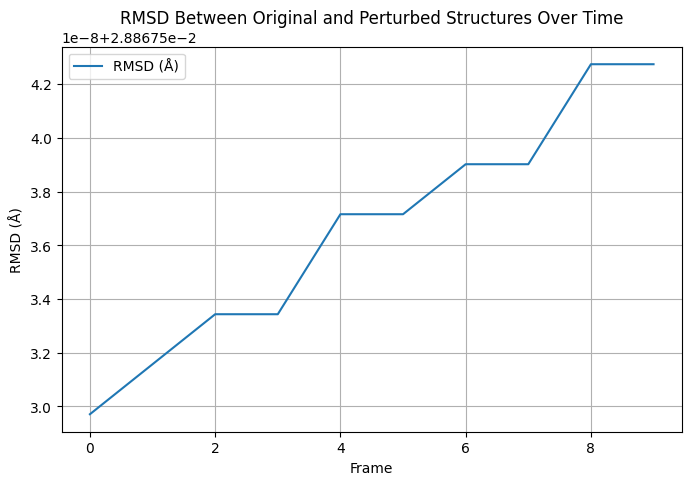

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rms

def generate_trajectory(universe, num_frames=10, frequency=528, amplitude=0.05):
    """
    Generate a fake trajectory by applying perturbations over multiple frames.
    """
    omega = 2 * np.pi * frequency
    trajectory = []

    for i in range(num_frames):
        # Apply a slight perturbation to the coordinates
        for atom in universe.atoms:
            x, y, z = atom.position
            atom.position = [
                x + amplitude * np.sin(omega * i),
                y + amplitude * np.cos(omega * i),
                z + amplitude * np.sin(omega * i)
            ]
        # Save the current frame
        trajectory.append(universe.atoms.positions.copy())

    return trajectory

# Generate a trajectory with 10 frames for the original structure
original_trajectory = generate_trajectory(u, num_frames=10)

# Generate a trajectory with 10 frames for the perturbed structure
perturbed_trajectory = generate_trajectory(perturbed, num_frames=10)

# Calculate RMSD for each frame
rmsd_values = []
for i in range(len(original_trajectory)):
    rmsd_value = np.sqrt(np.mean((original_trajectory[i] - perturbed_trajectory[i])**2))
    rmsd_values.append(rmsd_value)

# Plot the RMSD values
plt.figure(figsize=(8, 5))
plt.plot(rmsd_values, label='RMSD (Å)')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('RMSD Between Original and Perturbed Structures Over Time')
plt.legend()
plt.grid(True)
plt.show()



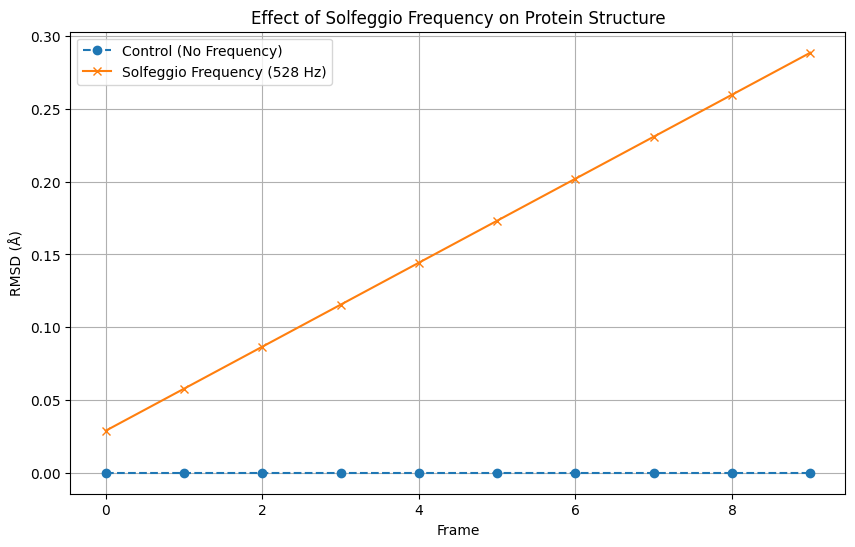

Mean RMSD (Control): 0.00 Å
Mean RMSD (Perturbed): 0.16 Å
The Solfeggio frequency appears to increase the structural deviation.


In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rms

def generate_trajectory(universe, num_frames=10, apply_frequency=False, frequency=528, amplitude=0.05):
    """
    Generate a fake trajectory with or without Solfeggio frequency perturbation.
    """
    omega = 2 * np.pi * frequency
    trajectory = []

    for i in range(num_frames):
        if apply_frequency:
            # Apply Solfeggio frequency perturbation
            for atom in universe.atoms:
                x, y, z = atom.position
                atom.position = [
                    x + amplitude * np.sin(omega * i),
                    y + amplitude * np.cos(omega * i),
                    z + amplitude * np.sin(omega * i)
                ]
        trajectory.append(universe.atoms.positions.copy())

    return trajectory

def calculate_rmsd(original_positions, trajectory):
    """
    Calculate RMSD between the original positions and the generated trajectory.
    """
    rmsd_values = []
    for frame in trajectory:
        rmsd = np.sqrt(np.mean((original_positions - frame) ** 2))
        rmsd_values.append(rmsd)
    return rmsd_values

# Load the original protein structure
u = mda.Universe("/content/alpha_synuclein.pdb")
original_positions = u.atoms.positions.copy()

# Generate control trajectory (without frequency)
control_trajectory = generate_trajectory(u, num_frames=10, apply_frequency=False)

# Generate perturbed trajectory (with Solfeggio frequency)
perturbed_trajectory = generate_trajectory(u, num_frames=10, apply_frequency=True, frequency=528)

# Calculate RMSD for both trajectories
rmsd_control = calculate_rmsd(original_positions, control_trajectory)
rmsd_perturbed = calculate_rmsd(original_positions, perturbed_trajectory)

# Plot the results for comparison
plt.figure(figsize=(10, 6))
plt.plot(rmsd_control, label='Control (No Frequency)', linestyle='--', marker='o')
plt.plot(rmsd_perturbed, label='Solfeggio Frequency (528 Hz)', linestyle='-', marker='x')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('Effect of Solfeggio Frequency on Protein Structure')
plt.legend()
plt.grid(True)
plt.show()

# Statistical Analysis: Compare the means of the two RMSD distributions
mean_control = np.mean(rmsd_control)
mean_perturbed = np.mean(rmsd_perturbed)
print(f"Mean RMSD (Control): {mean_control:.2f} Å")
print(f"Mean RMSD (Perturbed): {mean_perturbed:.2f} Å")

if mean_perturbed > mean_control:
    print("The Solfeggio frequency appears to increase the structural deviation.")
else:
    print("The Solfeggio frequency does not have a significant effect.")


/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


Analyzing frequency: 174 Hz
Analyzing frequency: 285 Hz
Analyzing frequency: 396 Hz
Analyzing frequency: 528 Hz
Analyzing frequency: 639 Hz
Analyzing frequency: 741 Hz
Analyzing frequency: 852 Hz
Analyzing frequency: 1000 Hz


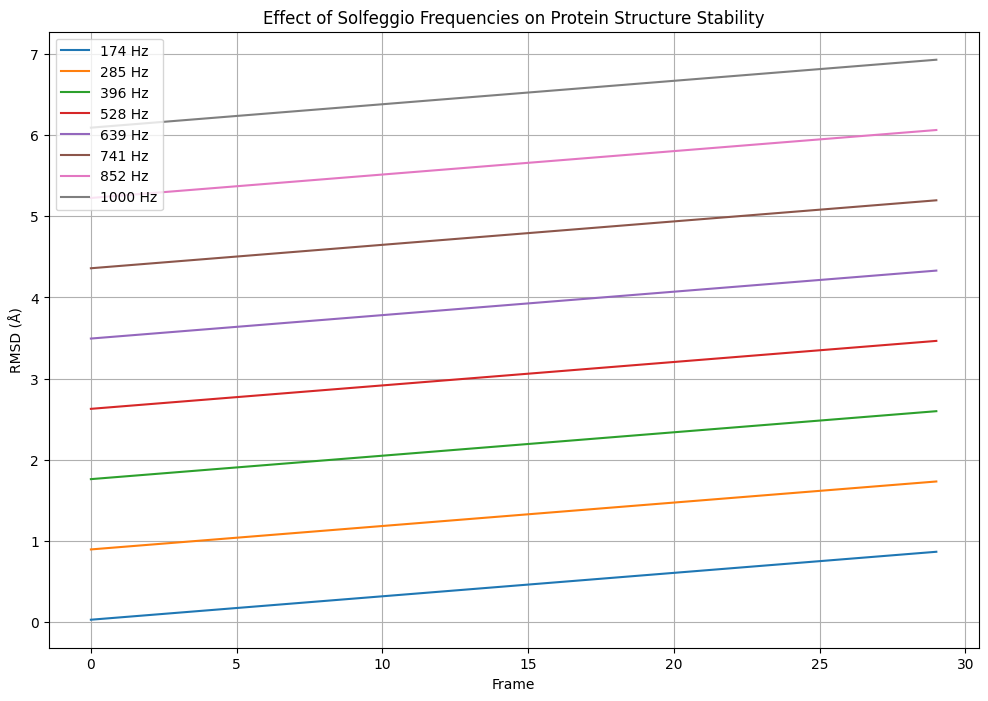


Frequencies sorted by RMSD (stabilizing to destabilizing):
Frequency 174 Hz: Mean RMSD = 0.447 Å
Frequency 285 Hz: Mean RMSD = 1.313 Å
Frequency 396 Hz: Mean RMSD = 2.180 Å
Frequency 528 Hz: Mean RMSD = 3.046 Å
Frequency 639 Hz: Mean RMSD = 3.912 Å
Frequency 741 Hz: Mean RMSD = 4.778 Å
Frequency 852 Hz: Mean RMSD = 5.644 Å
Frequency 1000 Hz: Mean RMSD = 6.510 Å


In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# List of Solfeggio frequencies to test
frequencies = [174, 285, 396, 528, 639, 741, 852]

def generate_trajectory(universe, num_frames=30, frequency=528, amplitude=0.05):
    """
    Generate a trajectory by applying Solfeggio frequency perturbation.
    """
    omega = 2 * np.pi * frequency
    trajectory = []

    for i in range(num_frames):
        # Apply Solfeggio frequency perturbation
        for atom in universe.atoms:
            x, y, z = atom.position
            atom.position = [
                x + amplitude * np.sin(omega * i),
                y + amplitude * np.cos(omega * i),
                z + amplitude * np.sin(omega * i)
            ]
        trajectory.append(universe.atoms.positions.copy())

    return trajectory

def calculate_rmsd(original_positions, trajectory):
    """
    Calculate RMSD of each frame in the trajectory relative to the original positions.
    """
    rmsd_values = []
    for frame in trajectory:
        rmsd = np.sqrt(np.mean((original_positions - frame) ** 2))
        rmsd_values.append(rmsd)
    return rmsd_values

# Load the original protein structure
topology_file = "alpha_synuclein.pdb"
u = mda.Universe(topology_file)
original_positions = u.atoms.positions.copy()

# Store RMSD results for different frequencies
rmsd_results = {}

# Generate trajectories and calculate RMSD for each frequency
for freq in frequencies:
    print(f"Analyzing frequency: {freq} Hz")
    perturbed_trajectory = generate_trajectory(u, num_frames=30, frequency=freq)
    rmsd_values = calculate_rmsd(original_positions, perturbed_trajectory)
    rmsd_results[freq] = rmsd_values

# Plot the RMSD results for each frequency
plt.figure(figsize=(12, 8))
for freq, rmsd_values in rmsd_results.items():
    plt.plot(rmsd_values, label=f'{freq} Hz')

plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('Effect of Solfeggio Frequencies on Protein Structure Stability')
plt.legend()
plt.grid(True)
plt.show()

# Analyze which frequencies have the most stabilizing (lowest RMSD) vs destabilizing (highest RMSD) effects
mean_rmsd = {freq: np.mean(values) for freq, values in rmsd_results.items()}
sorted_rmsd = sorted(mean_rmsd.items(), key=lambda x: x[1])

print("\nFrequencies sorted by RMSD (stabilizing to destabilizing):")
for freq, rmsd in sorted_rmsd:
    print(f"Frequency {freq} Hz: Mean RMSD = {rmsd:.3f} Å")


In [ ]:
# Load a trajectory file (e.g., .xtc, .dcd) along with a topology file
u = mda.Universe("topology.pdb", "trajectory.xtc")
perturbed = mda.Universe("topology.pdb", "perturbed_trajectory.xtc")

# Perform RMSD analysis across all frames
rmsd_analysis = rms.RMSD(u, perturbed, select='protein')
rmsd_analysis.run()

# Extract and plot RMSD values
rmsd_values = rmsd_analysis.rmsd[:, 2]
plt.figure(figsize=(8, 5))
plt.plot(rmsd_values, label='RMSD (Å)')
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.title('RMSD Across Trajectory')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install mdtraj


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 84.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


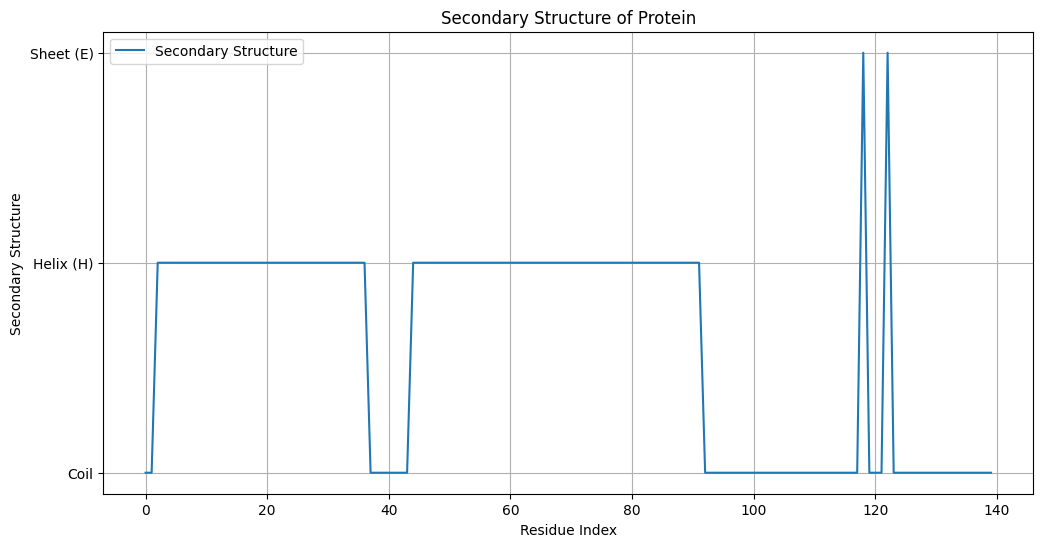

In [ ]:
import mdtraj as md
import matplotlib.pyplot as plt

# Load the protein structure and trajectory file
topology_file = 'alpha_synuclein.pdb'
trajectory_file = 'perturbed_structure.pdb'

# Load the trajectory into MDTraj
traj = md.load(trajectory_file, top=topology_file)

# Use MDTraj to calculate the secondary structure using DSSP
secondary_structure = md.compute_dssp(traj)

# The secondary structure is an array of characters where 'H' is alpha-helix, 'E' is beta-sheet, etc.
# You can plot the secondary structure assignments

# Convert the secondary structure to a numerical format for plotting
ss_numeric = [1 if res == 'H' else 2 if res == 'E' else 0 for res in secondary_structure[0]]  # Access the first frame's data
# Plot the secondary structure
plt.figure(figsize=(12, 6))
plt.plot(ss_numeric, label="Secondary Structure")
plt.yticks([0, 1, 2], ['Coil', 'Helix (H)', 'Sheet (E)'])
plt.xlabel("Residue Index")
plt.ylabel("Secondary Structure")
plt.title("Secondary Structure of Protein")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00
  Created wheel for nglview: filename=nglview-3.1.2-py3-none-any.whl size=7493363 sha256=8cc65e73e3181e706d593be75f08b4a074ccfc1fb3c6760c7d3492dceca5c41a
  Stored in directory: /root/.cache/pip/wheels/59/77/6c/bc7d0f3cdeb55b129e2ffccc88ef3ea935b0c8000d21d9f6e4
Successfully built nglview
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnb

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import files

# Upload your PDB file
uploaded = files.upload()

Saving alpha_synuclein.pdb to alpha_synuclein (1).pdb


In [ ]:
uploaded

{'alpha_synuclein (1).pdb': b'HEADER    LIPID BINDING PROTEIN                   11-OCT-04   1XQ8              \nTITLE     HUMAN MICELLE-BOUND ALPHA-SYNUCLEIN                                   \nCOMPND    MOL_ID: 1;                                                            \nCOMPND   2 MOLECULE: ALPHA-SYNUCLEIN;                                           \nCOMPND   3 CHAIN: A;                                                            \nCOMPND   4 SYNONYM: NON-A BETA COMPONENT OF AD AMYLOID, NON-A4 COMPONENT OF     \nCOMPND   5 AMYLOID, NACP;                                                       \nCOMPND   6 ENGINEERED: YES                                                      \nSOURCE    MOL_ID: 1;                                                            \nSOURCE   2 ORGANISM_SCIENTIFIC: HOMO SAPIENS;                                   \nSOURCE   3 ORGANISM_COMMON: HUMAN;                                              \nSOURCE   4 ORGANISM_TAXID: 9606;                                    

In [ ]:
!pip install nglview
!pip install py3Dmol

In [ ]:
import py3Dmol

# Open the PDB file as a string
with open("alpha_synuclein.pdb") as f:
    pdb_data = f.read()

# Visualize the structure using py3Dmol
view = py3Dmol.view(width=800, height=400)
view.addModel(pdb_data, "pdb")
view.setStyle({"cartoon": {"color": "blue"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import py3Dmol

# Open the PDB file as a string
with open("perturbed_structure.pdb") as f:
    pdb_data = f.read()

# Visualize the structure using py3Dmol
view = py3Dmol.view(width=800, height=400)
view.addModel(pdb_data, "pdb")
view.setStyle({"cartoon": {"color": "blue"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import py3Dmol

# Load the original structure (control)
with open("alpha_synuclein.pdb") as f:
    original_pdb = f.read()

# Load the perturbed structure (frequency-applied)
with open("perturbed_structure.pdb") as f:
    perturbed_pdb = f.read()

# Create a py3Dmol view
view = py3Dmol.view(width=1000, height=400)

# Add the original (control) structure to the view
view.addModel(original_pdb, "pdb")
view.setStyle({"cartoon": {"color": "blue"}})  # Blue for the original structure

# Add the perturbed structure to the same view
view.addModel(perturbed_pdb, "pdb")
view.setStyle({"cartoon": {"color": "red"}})  # Orange for the perturbed structure

# Zoom to fit both structures
view.zoomTo()

# Show the 3D visualization
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
!pip install openmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 62.4 MB/s eta 0:00:00


In [ ]:
from openmm import app, unit
from openmm.app import PDBFile, ForceField, Modeller
from openmm import Platform, LangevinIntegrator
import numpy as np
import math
import openmm

# Define the Solfeggio frequency (e.g., 528 Hz)
frequency = 528.0  # Solfeggio frequency in Hz
amplitude = 0.1  # Amplitude of the force applied (can be adjusted)

# Load the PDB file
pdb_file = "alpha_synuclein.pdb"  # PDB file of alpha-synuclein
pdb = PDBFile(pdb_file)

# Create a modeller object to add water and ions if necessary
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')  # Common forcefield
modeller = Modeller(pdb.topology, pdb.positions)

# Add solvent (water) and ions if necessary (e.g., for a physiological environment)
modeller.addSolvent(forcefield, model='tip3p', padding=1.0*unit.nanometers)

# Create the OpenMM system
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

# Set up the integrator (Langevin integrator for temperature control)
integrator = LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 0.001*unit.picoseconds)

# Choose the platform (CPU or GPU)
platform = Platform.getPlatformByName('CPU')  # Use 'CUDA' for GPU if available

# Create the simulation object
simulation = app.Simulation(modeller.topology, system, integrator, platform)

# Set up the initial conditions for the simulation
simulation.context.setPositions(modeller.positions)

# Perform energy minimization (relax the system)
print("Starting energy minimization...")
#simulation.minimizeEnergy()  # This minimizes the energy of the system
print("Energy minimization completed.")

# Apply the Solfeggio frequency force to the atoms
# Define a custom force (for oscillation) on a subset of atoms
custom_force = openmm.CustomExternalForce('F = A * sin(2 * pi * f * t)')  # Force equation
custom_force.addPerParticleParameter('A')  # Amplitude
custom_force.addPerParticleParameter('f')  # Frequency

for i, atom in enumerate(modeller.topology.atoms()):
    # Assign amplitude and frequency to each atom (here we apply the same for simplicity)
    custom_force.addParticle(i, [amplitude, frequency])

# Add the custom force to the system
system.addForce(custom_force)

Starting energy minimization...
Energy minimization completed.


5

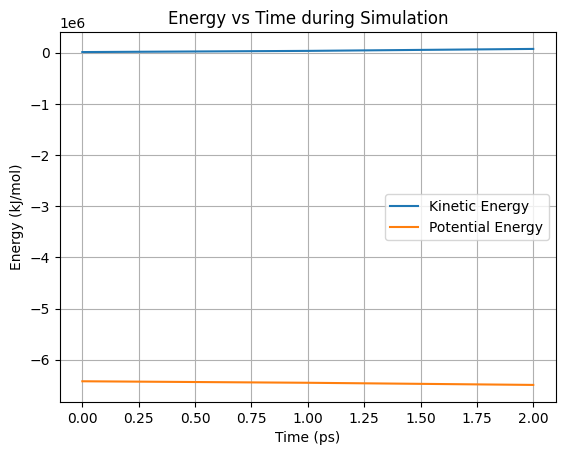

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store energy data
kinetic_energies = []
potential_energies = []

# Function to extract energy at each step and append to the lists
def energy_analysis(simulation):
    state = simulation.context.getState(getEnergy=True)
    kinetic_energy = state.getKineticEnergy()
    potential_energy = state.getPotentialEnergy()

    # Append energy values (converted to kJ/mol for clarity)
    kinetic_energies.append(kinetic_energy.value_in_unit(unit.kilojoules_per_mole))
    potential_energies.append(potential_energy.value_in_unit(unit.kilojoules_per_mole))

# Run the simulation for multiple steps and record energy data
num_steps = 3  # Number of steps you want to simulate

# Run the simulation and track energy at each step
for step in range(num_steps):
    simulation.step(1)  # Perform one step
    energy_analysis(simulation)  # Analyze energy after each step

# Now, plot the energy over time
plt.plot(kinetic_energies, label="Kinetic Energy")
plt.plot(potential_energies, label="Potential Energy")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (kJ/mol)")
plt.legend()
plt.title("Energy vs Time during Simulation")
plt.grid(True)
plt.show()


In [ ]:
# Run the simulation for a certain number of steps
#num_steps = 3  # Number of steps you want to simulate
#simulation.step(num_steps)  # Run the simulation

# After simulation is complete, save the final structure to a PDB file
final_positions = simulation.context.getState(getPositions=True).getPositions()  # Get the final positions
PDBFile.writeFile(modeller.topology, final_positions, open('simulation_output.pdb', 'w'))  # Save to PDB file

print("Simulation complete. Final structure saved to 'simulation_output.pdb'.")

Simulation complete. Final structure saved to 'simulation_output.pdb'.


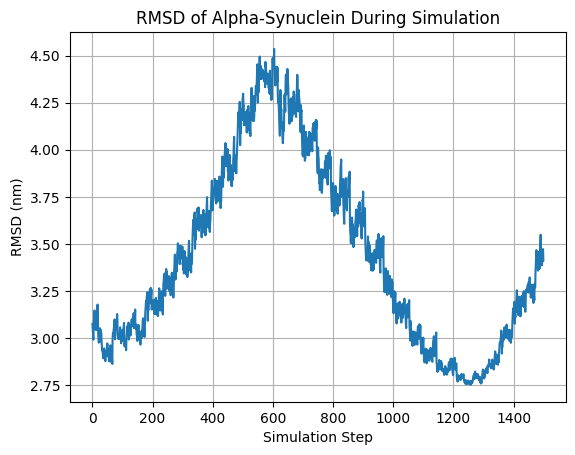

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from openmm import app, unit

# Load the initial PDB file (the reference structure)
initial_pdb = app.PDBFile("alpha_synuclein.pdb")
initial_positions = initial_pdb.getPositions()
initial_positions = np.array(initial_positions) * unit.nanometers  # Convert to nanometers

# Function to calculate RMSD between initial positions and trajectory positions
def calculate_rmsd(initial_positions, trajectory_positions):
    """Calculate RMSD over multiple frames"""
    rmsd_values = []
    for positions in trajectory_positions[:1500]:
        diff = positions - initial_positions
        squared_diff = np.square(diff)
        rmsd_values.append(np.sqrt(np.mean(squared_diff)))
    return np.array(rmsd_values)

# Load the saved simulation PDB file (output from the simulation)
simulation_output_pdb = "simulation_output.pdb"  # Output PDB file from the simulation

# Use OpenMM's PDBFile to read the PDB file
pdb = app.PDBFile(simulation_output_pdb)

# Extract positions from the PDB file
trajectory_positions = np.array(pdb.getPositions()) * unit.nanometers  # Convert to nanometers

# Calculate RMSD over time (trajectory vs initial)
rmsd_values = calculate_rmsd(initial_positions, trajectory_positions)

# Plot RMSD values over time
plt.plot(rmsd_values)
plt.xlabel('Simulation Step')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of Alpha-Synuclein During Simulation')
plt.grid(True)
plt.show()




Initial Radius of Gyration: 4.746 nm
Output Radius of Gyration: 8.582 nm


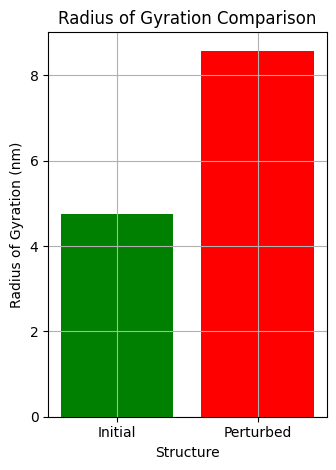

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from openmm import app, unit

# Load the initial PDB file (reference structure)
initial_pdb = app.PDBFile("alpha_synuclein.pdb")
initial_positions = np.array(initial_pdb.getPositions().value_in_unit(unit.nanometers))

# Load the simulation output PDB file (perturbed structure)
simulation_output_pdb = "simulation_output.pdb"
output_pdb = app.PDBFile(simulation_output_pdb)
output_positions = np.array(output_pdb.getPositions().value_in_unit(unit.nanometers))

# Step 2: Calculate Radius of Gyration (Rg)
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    diff = positions - center_of_mass
    squared_distances = np.sum(np.square(diff), axis=1)
    rg = np.sqrt(np.mean(squared_distances))
    return rg

# Calculate Rg for initial and perturbed structures
rg_initial = calculate_radius_of_gyration(initial_positions)
rg_output = calculate_radius_of_gyration(output_positions)
print(f"Initial Radius of Gyration: {rg_initial:.3f} nm")
print(f"Output Radius of Gyration: {rg_output:.3f} nm")

labels = ['Initial', 'Perturbed']
rg_values = [rg_initial, rg_output]
# Plot Radius of Gyration
plt.subplot(1, 2, 2)
plt.bar(labels, rg_values, color=['green', 'red'])
plt.xlabel('Structure')
plt.ylabel('Radius of Gyration (nm)')
plt.title('Radius of Gyration Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()


Before Simulation - Alpha-helices: 18, Beta-sheets: 706
After Simulation - Alpha-helices: 18, Beta-sheets: 704


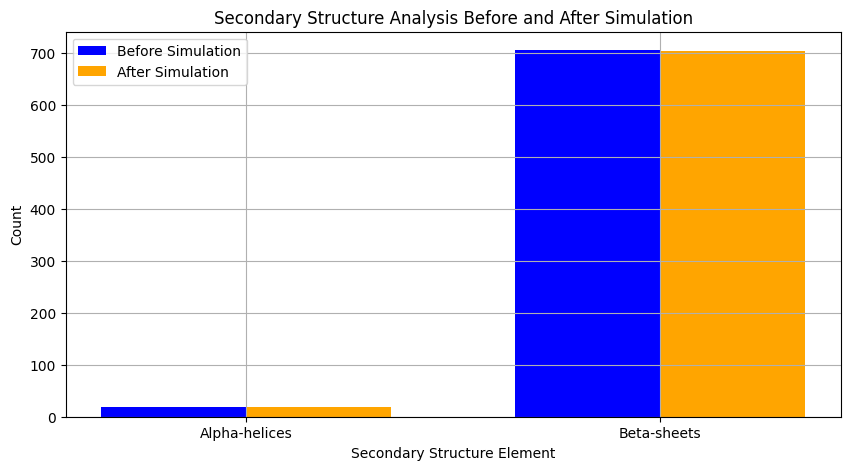

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from openmm import app, unit

# Load the initial PDB file (reference structure)
initial_pdb = app.PDBFile("alpha_synuclein.pdb")
initial_positions = np.array(initial_pdb.getPositions().value_in_unit(unit.nanometers))

# Load the simulation output PDB file (perturbed structure)
simulation_output_pdb = "simulation_output.pdb"
output_pdb = app.PDBFile(simulation_output_pdb)
output_positions = np.array(output_pdb.getPositions().value_in_unit(unit.nanometers))

# Helper function to calculate distances between atoms
def calculate_distance(pos1, pos2):
    return np.sqrt(np.sum((pos1 - pos2) ** 2))

# Step 1: Simplistic calculation of alpha-helices
def count_alpha_helices(positions):
    helix_count = 0
    for i in range(len(positions) - 4):
        dist = calculate_distance(positions[i], positions[i + 4])
        # Typical distance for alpha-helices between i and i+4 is around 0.5 nm
        if 0.45 < dist < 0.55:
            helix_count += 1
    return helix_count

# Step 2: Simplistic calculation of beta-sheets
def count_beta_sheets(positions):
    sheet_count = 0
    for i in range(len(positions) - 1):
        for j in range(i + 5, len(positions)):
            dist = calculate_distance(positions[i], positions[j])
            # Typical distance for hydrogen bonds in beta-sheets is around 0.3 to 0.5 nm
            if 0.3 < dist < 0.5:
                sheet_count += 1
    return sheet_count

# Calculate secondary structure elements before and after simulation
helices_before = count_alpha_helices(initial_positions[:100])
sheets_before = count_beta_sheets(initial_positions[:100])

helices_after = count_alpha_helices(output_positions[:100])
sheets_after = count_beta_sheets(output_positions[:100])

# Print the results
print(f"Before Simulation - Alpha-helices: {helices_before}, Beta-sheets: {sheets_before}")
print(f"After Simulation - Alpha-helices: {helices_after}, Beta-sheets: {sheets_after}")

# Step 3: Plot the secondary structure changes
labels = ['Alpha-helices', 'Beta-sheets']
before = [helices_before, sheets_before]
after = [helices_after, sheets_after]

plt.figure(figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, before, bar_width, label='Before Simulation', color='blue')
plt.bar(x + bar_width/2, after, bar_width, label='After Simulation', color='orange')

plt.xlabel('Secondary Structure Element')
plt.ylabel('Count')
plt.title('Secondary Structure Analysis Before and After Simulation')
plt.xticks(x, labels)
plt.legend()
plt.grid(True)
plt.show()
